# E8. 인물 사진 모드

[ 이미지 세그멘테이션 정리 ](https://velog.io/@dongho5041/%EB%94%A5%EB%9F%AC%EB%8B%9D-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%84%B8%EA%B7%B8%EB%A9%98%ED%85%8C%EC%9D%B4%EC%85%98Image-Segmentation)

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib
from PIL import Image

from matplotlib import pyplot as plt
import tensorflow as tf

## 이미지 불러오기

이미지 사이즈는 (746, 750, 3)이다.


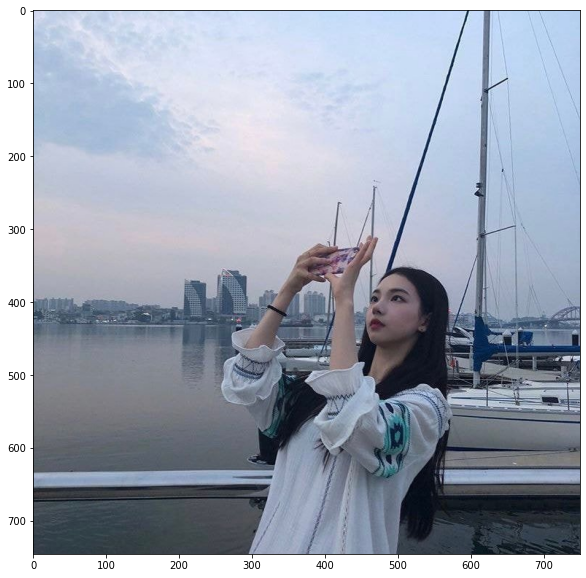

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/카리나3.jpg' 
img_orig = cv2.imread(img_path) 
print ('이미지 사이즈는 {}이다.'.format(img_orig.shape))

plt.figure(figsize=(10, 10)) # 출력 사이즈 조정

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## Segmentation 적용
사전학습된 DeepLab 모델 사용

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

#### 모델 정의 및 다운로드, 사전학습된 가중치 불러오기

In [4]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir) # 디렉토리와 모든 상위/중간 디렉토리를 생성

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path): # 지정된 경로가 존재하는지 여부 파악, 없으면 밑의 코드 실행
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path) # URL로 표시된 네트워크 객체를 로컬 파일로 복사

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


#### Segmentation
run 메소드를 통해 Segmentation 적용 -> Resized된 이미지와 class로 구분되어 있는 Segmentation Featuremap 생성

In [5]:
#첫 단계에서 준비한 이미지 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig) # 이미지 리사이즈
print (img_orig.shape, img_resized.shape, seg_map.max())

(746, 750, 3) (510, 513, 3) 15


In [6]:
# 구글이 제공한 DeepLab의 PASCAL VOC Label
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
print('DeepLab 모델이 구분할 수 있는 피사체의 개수 : ', len(LABEL_NAMES))

DeepLab 모델이 구분할 수 있는 피사체의 개수 :  21


#### Segmentation 결과 시각화

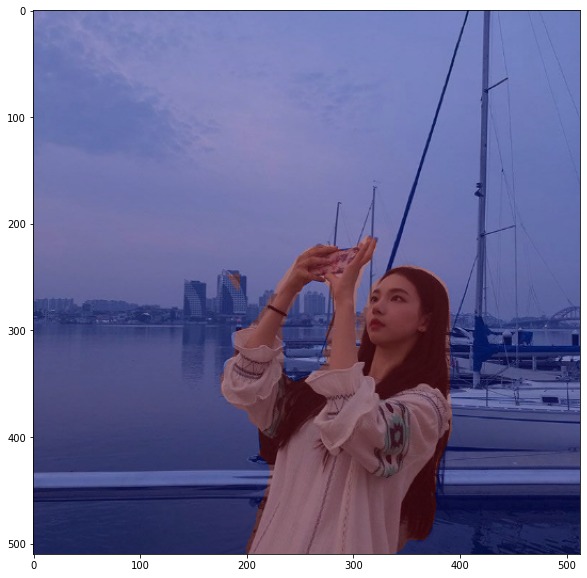

In [7]:
# 사람(Label 15)를 가진 영역만 검출
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.figure(figsize=(10,10))

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

* Preprocess를 통과하면서 입력한 이미지 사이즈와 mask 크기가 달라져 복원을 한다.

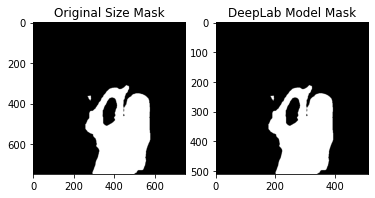

In [8]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### 배경 Blur 처리
Blur메소드 내부의 (25, 25)는 sigma값으로 Blur의 정도 조절  
sigma 값이 높을수록 인물이 더욱 focusing된다.

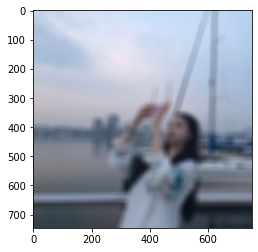

In [9]:
# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (25,25))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출하기

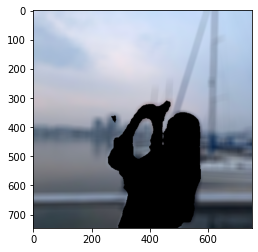

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### Focus Image 생성

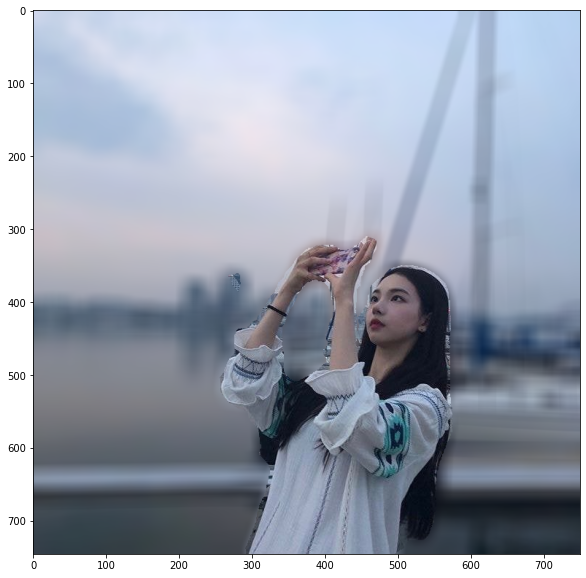

In [11]:
plt.figure(figsize=(10,10))

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 강아지에 적용

이미지사이즈는 (1280, 960, 3)이다.


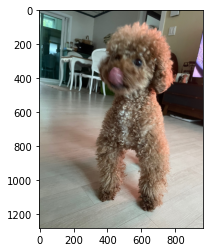

In [12]:
# 이미지 불러오기
dog_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/루키1.jpg' 
dog_img_orig = cv2.imread(dog_img_path) 
print ('이미지사이즈는 {}이다.'.format(dog_img_orig.shape))

plt.imshow(cv2.cvtColor(dog_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

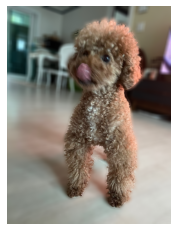

In [13]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(dog_img_orig)

#  강아지(dog) 라벨(12)를 가진 영역만 검출하기
dog_img_show = img_resized.copy()
seg_map = np.where(seg_map == 12, 12, 0) # 예측 중 강아지만 추출
dog_img_mask = seg_map * (255/seg_map.max()) # 255 normalization
dog_img_mask = dog_img_mask.astype(np.uint8)
dog_color_mask = cv2.applyColorMap(dog_img_mask, cv2.COLORMAP_JET)
dog_img_show = cv2.addWeighted(dog_img_show, 0.6, dog_color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask)를 원래 크기로 복원
dog_img_mask_up = cv2.resize(dog_img_mask, dog_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, dog_img_mask_up = cv2.threshold(dog_img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 흐리게 하기
dog_img_orig_blur = cv2.blur(dog_img_orig, (25,25)) #(25,25)은 blurring  kernel size를 뜻합니다. 

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기
dog_img_mask_color = cv2.cvtColor(dog_img_mask_up, cv2.COLOR_GRAY2BGR)
dog_img_bg_mask = cv2.bitwise_not(dog_img_mask_color)
dog_img_bg_blur = cv2.bitwise_and(dog_img_orig_blur, dog_img_bg_mask)

# 배경 영상과 강아지 영상을 합치기
dog_img_concat = np.where(dog_img_mask_color==255, dog_img_orig, dog_img_bg_blur)
plt.imshow(cv2.cvtColor(dog_img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

이미지 사이즈는 (650, 1128, 3)이다.


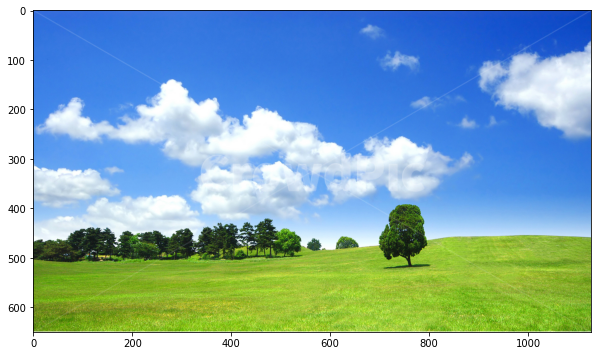

In [14]:
# 배경으로 사용할 사진을 불러온다
bgnd_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/초원.jpg' 
bgnd_orig = cv2.imread(bgnd_path)
print ('이미지 사이즈는 {}이다.'.format(bgnd_orig.shape))

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(bgnd_orig, cv2.COLOR_BGR2RGB))
plt.show()

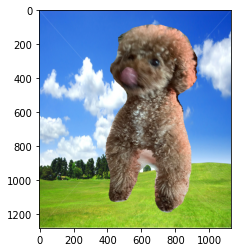

In [15]:
# 이미지, 배경사진, 이미지 mask 리사이즈
dog_resized = cv2.resize(dog_img_orig, (bgnd_orig.shape[1], dog_img_orig.shape[0]))
bgnd_img_resized = cv2.resize(bgnd_orig, (bgnd_orig.shape[1], dog_img_orig.shape[0]))

dog_img_mask_resized = cv2.resize(dog_img_mask_color, (bgnd_orig.shape[1], dog_img_orig.shape[0]))

# 배경 이미지와 강아지 이미지 합치기
dog_bgnd_concat = np.where(dog_img_mask_resized == 255, dog_resized, bgnd_img_resized)

plt.imshow(cv2.cvtColor(dog_bgnd_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 문제점 및 해결
1. 객체 주변 부자연스러운 경계선

#### 문제점. 객체 주변 부자연스러운 경계선

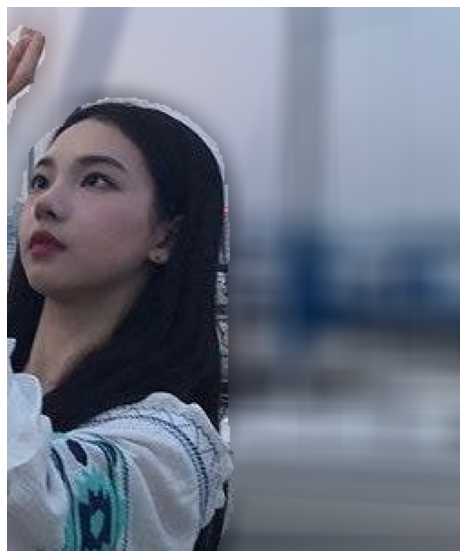

In [16]:
img_concat = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_concat[300:600, 450:700])
plt.axis("off"); plt.show()

#### 해결책
새로운 이미지를 통해 해결 방법을 찾아본다.

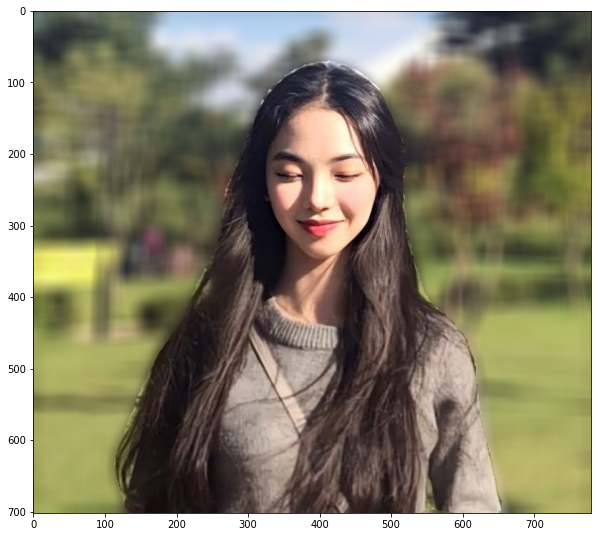

In [17]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/카리나7.jpg' 
img_orig = cv2.imread(img_path)

# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(img_orig)

#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람(LABEL_NAMES 15번째가 person)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 흐리게 하기
img_orig_blur = cv2.blur(img_orig, (25,25)) #(25,25)은 blurring  kernel size를 뜻합니다. 

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

# 배경 영상과 사람 영상을 합치기
plt.figure(figsize=(10, 10))

img_concat3 = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

* 역시 첫 번째 인물사진과 동일하게 윤곽선이 부자연스러운 현상을 볼 수 있다.

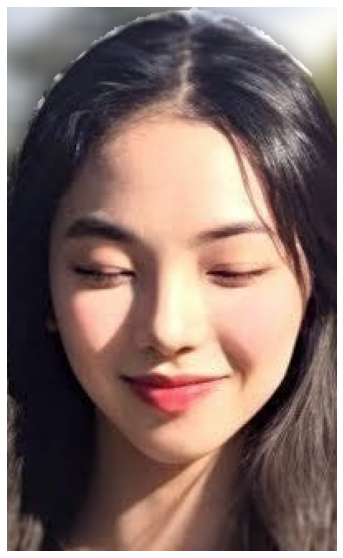

In [18]:
img_concat3 = cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_concat3[70:400, 300:500])
plt.axis("off"); plt.show()

#### Gaussian Blur
* Mask 이미지가 0과 1로 극단적으로 나눠져 있어 경계선이 발생한다.
* 마스크의 물체 테두리 부분에서 0과 1이 아닌 부드러운 곡선 형태의 step function이 필요하다. -> Gaussian Blur 사용


In [19]:
# img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_blur = img_Gmask*img_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output = (image_blur+img_bg_mask).astype(np.uint8)

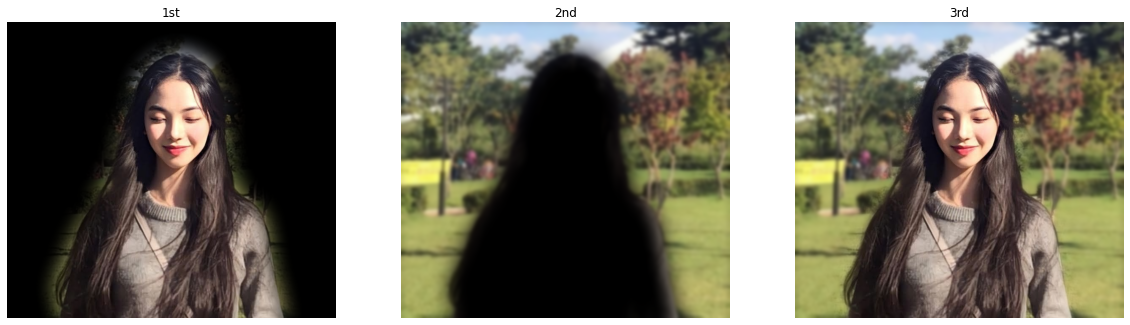

In [20]:
# GaussianBlur 처리한 부분을 확인하기
fig = plt.figure(figsize=(20, 10)) 

ax = plt.subplot(131)
plt.imshow(cv2.cvtColor(image_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('1st')
plt.axis('off')
ax = plt.subplot(132)
plt.imshow(cv2.cvtColor(img_bg_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('2nd')
plt.axis('off')
ax = plt.subplot(133)
plt.imshow(cv2.cvtColor(img_output,cv2.COLOR_BGR2RGB))
plt.title('3rd')
plt.axis('off')
plt.show()

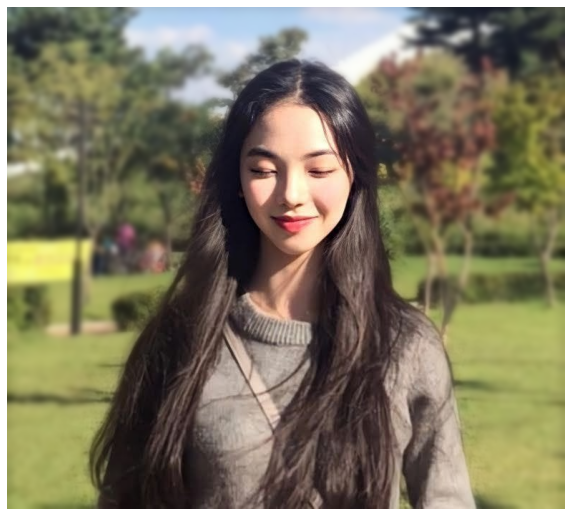

In [21]:
# 결과물 확인
plt.figure(figsize=(10, 10))

plt.imshow(cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### 결과
0과 1로만 이루어졌던 경계선에 비해 확실히 부드러운 경계선을 확인할 수 있다.

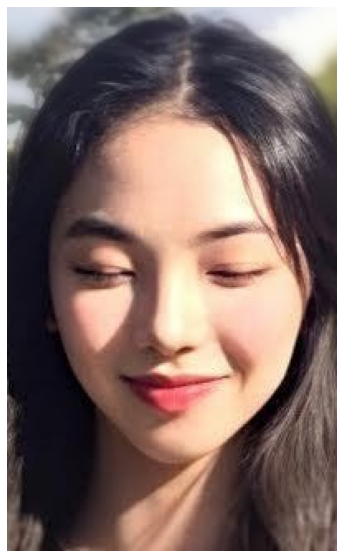

In [22]:
img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(img_output[70:400, 300:500])
plt.axis("off"); plt.show()

#### 처음 이미지에 적용

In [25]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/카리나3.jpg' 
img_orig = cv2.imread(img_path)

# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(img_orig)

#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람(LABEL_NAMES 15번째가 person)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_blur = img_Gmask*img_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output2 = (image_blur+img_bg_mask).astype(np.uint8)

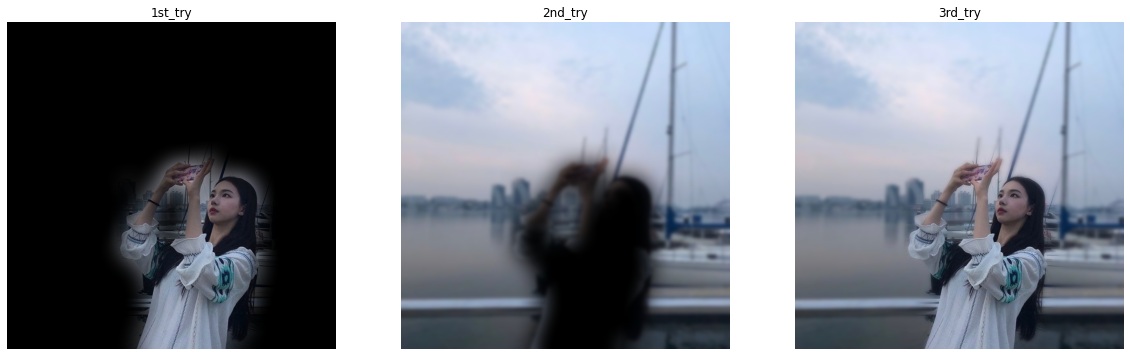

In [27]:
# GaussianBlur 전후 비교해서 확인하기
fig = plt.figure(figsize=(20, 10)) 


ax = plt.subplot(131)
plt.imshow(cv2.cvtColor(image_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('1st_try')
plt.axis('off')

ax = plt.subplot(132)
plt.imshow(cv2.cvtColor(img_bg_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.title('2nd_try')
plt.axis('off')

ax = plt.subplot(133)
plt.imshow(cv2.cvtColor(img_output2,cv2.COLOR_BGR2RGB))
plt.title('3rd_try')
plt.axis('off')

plt.show()

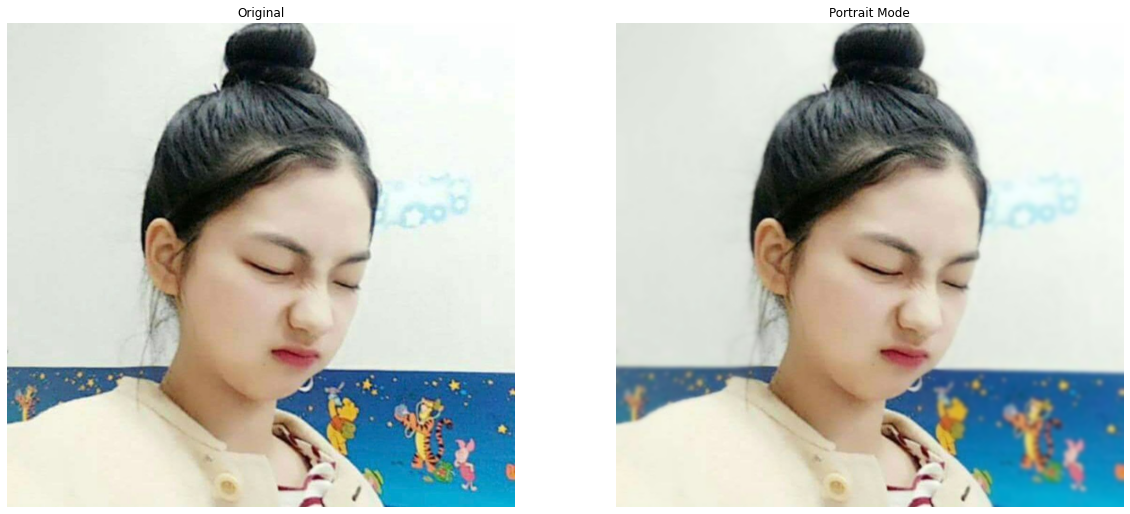

In [28]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/카리나8.jpg' 
img_orig = cv2.imread(img_path)

# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(img_orig)

#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람(LABEL_NAMES 15번째가 person)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_blur = img_Gmask*img_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output3 = (image_blur+img_bg_mask).astype(np.uint8)

# 이미지 출력
fig = plt.figure(figsize=(20,10))

ax = plt.subplot(121)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

ax = plt.subplot(122)
plt.imshow(cv2.cvtColor(img_output3, cv2.COLOR_BGR2RGB))
plt.title('Portrait Mode')
plt.axis('off')
plt.show()

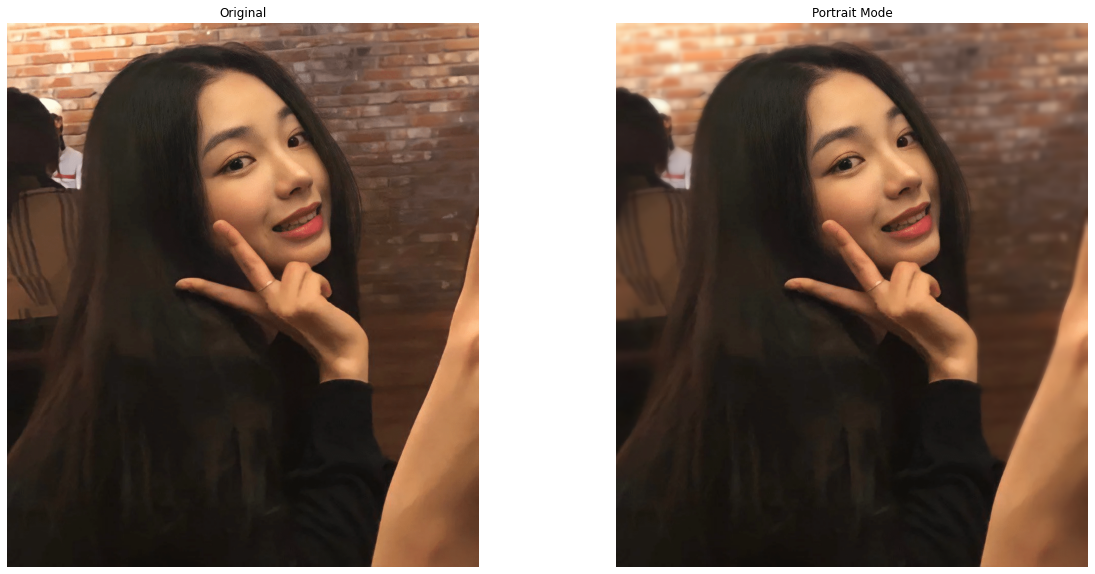

In [29]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/카리나.jpg' 
img_orig = cv2.imread(img_path)

# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(img_orig)

#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람(LABEL_NAMES 15번째가 person)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_blur = img_Gmask*img_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output3 = (image_blur+img_bg_mask).astype(np.uint8)

# 이미지 출력
fig = plt.figure(figsize=(20,10))

ax = plt.subplot(121)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

ax = plt.subplot(122)
plt.imshow(cv2.cvtColor(img_output3, cv2.COLOR_BGR2RGB))
plt.title('Portrait Mode')
plt.axis('off')
plt.show()

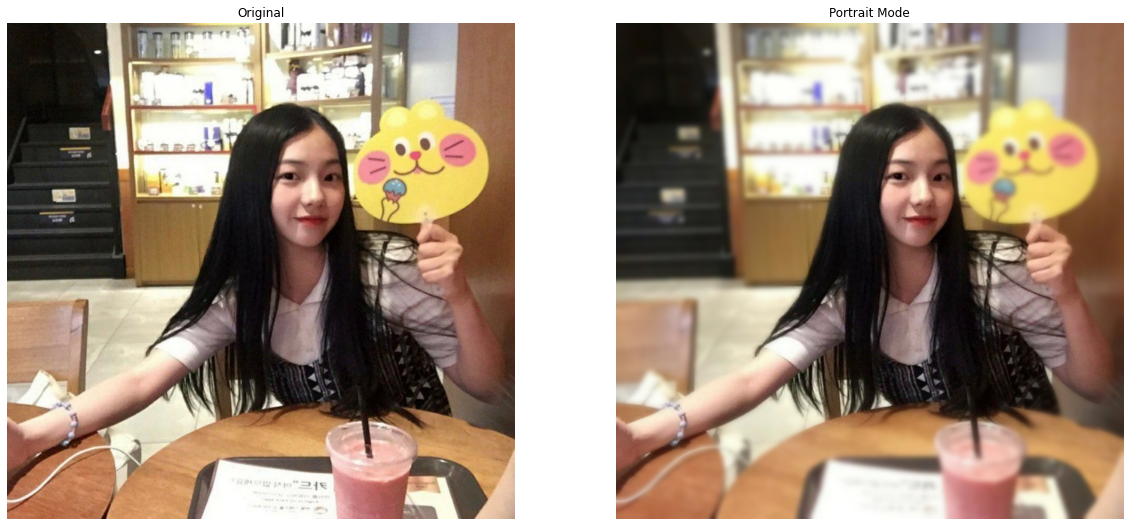

In [30]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/카리나1.jpg' 
img_orig = cv2.imread(img_path)

# 첫 단계에서 준비한 이미지를 네트워크에 입력하기
img_resized, seg_map = MODEL.run(img_orig)

#  사람(person) 라벨(15)를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람(LABEL_NAMES 15번째가 person)만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# img_mask_up의 채널을 원본 사진과 맞게 3 channel로 바꾼다.
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

# 원본 이미지를 가우시안 Blur 처리한다.
orig_Gblur = cv2.GaussianBlur(img_orig, (25,25),0)
# 마스크 이미지를 가우시안 Blur 처리한다.
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

# 마스크와 이미지를 더해준다.
image_blur = img_Gmask*img_orig.astype(np.float32)

# 1-마스크를 해줘서 Blur 처리한 원본에서 배경만 뽑아낸다.
img_bg_mask = (1-img_Gmask)*orig_Gblur.astype(np.float32)
img_output3 = (image_blur+img_bg_mask).astype(np.uint8)

# 이미지 출력
fig = plt.figure(figsize=(20,10))

ax = plt.subplot(121)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

ax = plt.subplot(122)
plt.imshow(cv2.cvtColor(img_output3, cv2.COLOR_BGR2RGB))
plt.title('Portrait Mode')
plt.axis('off')
plt.show()

# 결과
* 사람을 잘 구분해내는듯 했으나, 원치 않은 객체를 Segmentation하는 경우도 발생하곤 했다.
* 객체의 색이나 대상과의 거리에 따라 포커싱을 하게 되는 경우가 발생하는 것 같다.
* 윤곽선을 0과 1로만 구분하게 될 경우 경계선이 부자연스럽게 보일 수 있다.
* Gaussian Blur를 통해 부드러운 곡선의 Step function으로 만들어 자연스러운 윤곽선을 만들 수 있었다.